# Tick library - guide and testing

## Python Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw
import itertools

## Tick Imports

### Simulation

In [34]:
from tick.hawkes import SimuHawkes, SimuHawkesMulti

#### Non-parametric

In [35]:
from tick.base import TimeFunction
from tick.hawkes import HawkesKernelTimeFunc

#### Parametric

In [36]:
from tick.hawkes import HawkesKernelSumExp

### Learners

#### Non-parametric

In [37]:
from tick.hawkes import HawkesEM, HawkesBasisKernels

#### Parametric

In [38]:
from tick.hawkes import HawkesSumExpKern, HawkesSumGaussians

### Plotting kernels

In [39]:
from tick.plot import plot_timefunction
from tick.plot import plot_point_process
from tick.plot import plot_hawkes_kernel_norms, plot_hawkes_kernels
from tick.plot import plot_basis_kernels

## Defining Time Functions

In [40]:
support = 2

#### Using a function

In [41]:
def g1(t):
    return 0.7 * 0.5 * 10 * np.exp(-0.5 * 10 * t)

In [42]:
def g2(t):
    return 0.7 * 0.5 * 10 * np.exp(-0.5 * 10 * (t - 1))\
        * np.heaviside(t -1, 1)

In [43]:
xgrid = np.linspace(0, support, 20+1)

In [44]:
tf1 = TimeFunction((xgrid, g1(xgrid)), inter_mode=TimeFunction.InterConstRight)

In [45]:
tf2 = TimeFunction((xgrid, g2(xgrid)), inter_mode=TimeFunction.InterConstRight)

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


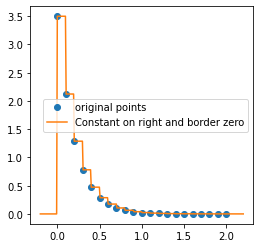

In [46]:
plot_timefunction(tf1)

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


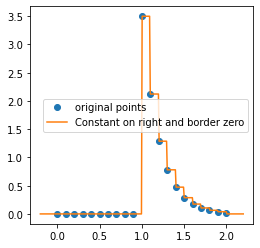

In [47]:
plot_timefunction(tf2)

## Defining Non-parametric Kernels

## Defining Parametric Kernels

## Simulations

## Learning